<a href="https://colab.research.google.com/github/SummerLife/EmbeddedSystem/blob/master/MachineLearning/gist/mobilenet_on_sign_language_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building A Fine-Tuned MobileNet Model

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

## Process The Data

In [25]:
data_set_dir = "/content/sign_language_digits_dataset"

# Sign Language Digits data set:
# https://github.com/ardamavi/Sign-Language-Digits-Dataset

# Organize data into train, valid, test dirs
# os.chdir(data_set_dir)
# if os.path.isdir('train/0/') is False: 
#     os.mkdir('train')
#     os.mkdir('valid')
#     os.mkdir('test')

#     for i in range(0, 10):
#         shutil.move(f'{i}', 'train')
#         os.mkdir(f'valid/{i}')
#         os.mkdir(f'test/{i}')

#         valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
#         for j in valid_samples:
#             shutil.move(f'train/{i}/{j}', f'valid/{i}')

#         test_samples = random.sample(os.listdir(f'train/{i}'), 5)
#         for k in test_samples:
#             shutil.move(f'train/{i}/{k}', f'test/{i}')
# os.chdir('../..')

In [26]:
train_path = data_set_dir + '/train'
valid_path = data_set_dir + '/valid'
test_path  = data_set_dir + '/test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


## Fine-Tuning MobileNet

In [27]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [28]:
# grab the output from the sixth to last layer of the model and store it in this variable x.
x = mobile.layers[-6].output
print(x)

Tensor("global_average_pooling2d_1/Identity:0", shape=(None, 1024), dtype=float32)


In [29]:
output = Dense(units=10, activation='softmax')(x)

In [30]:
model = Model(inputs=mobile.input, outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

we need to choose how many layers we actually want to be trained when we train on our new data set.

In [31]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [32]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

## Training The Model

In [33]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=30, verbose=2)

Epoch 1/30
172/172 - 5s - loss: 0.6319 - accuracy: 0.8160 - val_loss: 0.4088 - val_accuracy: 0.8767
Epoch 2/30
172/172 - 5s - loss: 0.1238 - accuracy: 0.9796 - val_loss: 0.1200 - val_accuracy: 0.9633
Epoch 3/30
172/172 - 5s - loss: 0.0562 - accuracy: 0.9959 - val_loss: 0.0720 - val_accuracy: 0.9833
Epoch 4/30
172/172 - 5s - loss: 0.0297 - accuracy: 0.9988 - val_loss: 0.0679 - val_accuracy: 0.9767
Epoch 5/30
172/172 - 5s - loss: 0.0295 - accuracy: 0.9959 - val_loss: 0.0852 - val_accuracy: 0.9667
Epoch 6/30
172/172 - 5s - loss: 0.0151 - accuracy: 0.9994 - val_loss: 0.0347 - val_accuracy: 0.9933
Epoch 7/30
172/172 - 5s - loss: 0.0115 - accuracy: 0.9994 - val_loss: 0.0316 - val_accuracy: 0.9933
Epoch 8/30
172/172 - 5s - loss: 0.0123 - accuracy: 0.9988 - val_loss: 0.0430 - val_accuracy: 0.9867
Epoch 9/30
172/172 - 5s - loss: 0.0111 - accuracy: 0.9988 - val_loss: 0.0340 - val_accuracy: 0.9967
Epoch 10/30
172/172 - 5s - loss: 0.0083 - accuracy: 0.9994 - val_loss: 0.0262 - val_accuracy: 0.9933

In [35]:
# %cp -r "/content/drive/My Drive/data_set_to_train/Sign-Language-Digits-Dataset/Dataset" /content/

In [36]:
test_labels = test_batches.classes

In [37]:
predictions = model.predict(x=test_batches, verbose=0)

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [39]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [40]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

Confusion matrix, without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


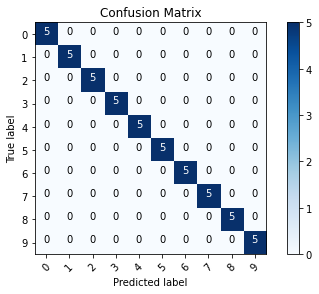

In [41]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')